In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


with open("dirty.json", "r") as file:
    data = json.load(file)

systemState = pd.read_csv('mem_res.csv').filter(regex='^((?!Unnamed).)*$')
sys_data = systemState.to_dict()
keys = systemState.columns
types = { v['type']:1 for adder,v in data.items()}

types_to_int = {string: i for i, string in enumerate(sorted(set(types )))}


encoded = [types_to_int[string] for string in types  ]


high_dirty_rate={}
low_page_num=0
high_apage_num=0
middle_page_num=0
all_num=0
for key , v in data.items():
    rate = sum(v["isDirtyList"])/len(v["isDirtyList"])
    if rate>0.1 and rate < 0.9:
        high_dirty_rate[key] = v
        middle_page_num+=1
    elif rate <=0.2:
        low_page_num +=1
    else:
       high_apage_num+=1
    all_num+=1
for adder , v in high_dirty_rate.items():
    for sys_key in keys:
        high_dirty_rate[adder][sys_key] = [s for s in sys_data[sys_key].values() ]
    high_dirty_rate[adder]['type'] = types_to_int[high_dirty_rate[adder]['type']]
    high_dirty_rate[adder].pop('isAccessed')
print(low_page_num,middle_page_num,high_apage_num)

1201 263427 51


In [3]:
# 前m-1时刻与第m时刻的相关性

import math
feature_matrix = []
maxsv = -math.inf
corr_matrix_list=[]
for adder in high_dirty_rate:
    df = pd.DataFrame(high_dirty_rate[adder ])
    lag_df = df.copy()
    #print(lag_df.columns)
    
    # Index(['isDirtyList', 'type', 'pgfaults', 'pgpgin', 'pgpgout',
    #    'ctxt', 'softirq', 'mem_free', 'mem_total', 'swap_free', 'swap_total',
    #    'read_bytes', 'write_bytes', 'flt'],
    #   dtype='object')
    lag_df['isDirtyList_lag'] = df['isDirtyList'].shift(-1)  # 创建isDirtyList的滞后特征

    # 删除最后一行，因为滞后特征会导致NaN
    lag_df = lag_df[:-1]

    # 计算相关性矩阵
    corr_matrix = lag_df.corr(method='spearman')

    # 获取isDirtyList_lag与其他特征的相关性
    isDirty_correlations = corr_matrix['isDirtyList_lag'].drop(['isDirtyList', 'isDirtyList_lag'])
    #print(isDirty_correlations.sort_values(ascending=False))
    highest_corr_feature = isDirty_correlations.idxmax()
    highest_corr_value = isDirty_correlations.max()
    #feature_matrix.append((highest_corr_feature, highest_corr_value))
    if highest_corr_value > maxsv:
        maxsv = highest_corr_value
        #print(adder,highest_corr_feature, highest_corr_value)
    if highest_corr_value > 0.8:
        feature_matrix.append((adder,highest_corr_feature, highest_corr_value))
        #print(adder,highest_corr_feature, highest_corr_value)
    if highest_corr_value > 0.8:
        corr_matrix_list.append(corr_matrix)
        #break
    if len(corr_matrix_list)>1000:
        break
    

/var/folders/zr/dvb9txgj40b71t1ywfg0xl3m0000gn/T/ipykernel_8464/4274308145.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping


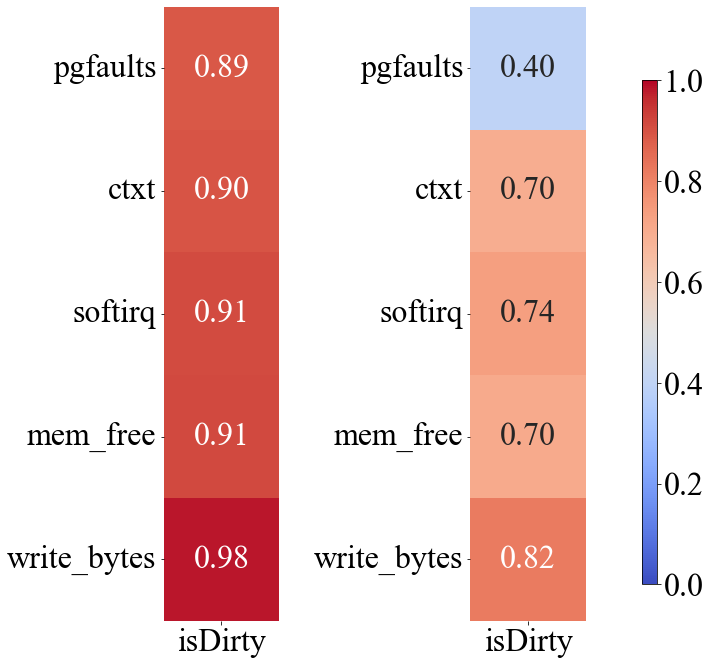

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Set the font and plot configurations for PDF output
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 32  # May need further adjustment
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
label_size = 44
tick_size = 32
linewidth = 2.5
legend_size = 28
mark_size = 10
bwith = 2

def plt_hot2(corr_matrix1, corr_matrix2, name):
    # Select specific columns and rename isDirtyList to isDirty
    columns_to_display = ["isDirtyList", "pgfaults", "ctxt", "softirq", "mem_free", "write_bytes"]
    corr_matrix1 = corr_matrix1[columns_to_display].rename(columns={"isDirtyList": "isDirty"})
    corr_matrix2 = corr_matrix2[columns_to_display].rename(columns={"isDirtyList": "isDirty"})

    # Calculate correlation matrix for the selected columns
    corr_matrix1 = corr_matrix1.corr()
    corr_matrix2 = corr_matrix2.corr()

    # Remove the first row
    corr_matrix1 = corr_matrix1.iloc[1:]
    corr_matrix2 = corr_matrix2.iloc[1:]

    # Extract the first column and drop NaN values
    first_col1 = corr_matrix1.iloc[:, 0].dropna()
    first_col2 = corr_matrix2.iloc[:, 0].dropna()
    
    # Convert non-NaN elements to DataFrame
    first_col_df1 = pd.DataFrame(first_col1)
    first_col_df2 = pd.DataFrame(first_col2)

    # Calculate the global minimum and maximum values
    vmin = min(first_col_df1.min().min(), first_col_df2.min().min(), 0)
    vmax = max(first_col_df1.max().max(), first_col_df2.max().max(), 1)

    # Increase figure width and adjust the height as needed to prevent overlap
    fig_width = 10  # Adjust width as needed
    fig_height = 10  # Keep the height or adjust as needed
    fig, ax = plt.subplots(1, 2, figsize=(fig_width, fig_height))

    # Plot the heatmaps
    sns.heatmap(first_col_df1, ax=ax[0], annot=True, fmt=".2f", cmap='coolwarm', vmin=vmin, vmax=vmax,
                annot_kws={"size": tick_size}, cbar=False)
    ax[0].tick_params(axis='y', labelsize=32)

    sns.heatmap(first_col_df2, ax=ax[1], annot=True, fmt=".2f", cmap='coolwarm', vmin=vmin, vmax=vmax,
                annot_kws={"size": tick_size}, cbar=False)
    ax[1].tick_params(axis='y', labelsize=32)

    # Add a color bar to the right of the heatmaps
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping
    plt.savefig(f'{name}.pdf', format='pdf', bbox_inches='tight', dpi=300)  # Save as PDF with high resolution
    plt.show()

# Assuming corr_matrix_list is defined and contains the correlation matrices
plt_hot2(corr_matrix_list[200], corr_matrix_list[987], "mem_hot")


/var/folders/zr/dvb9txgj40b71t1ywfg0xl3m0000gn/T/ipykernel_78129/4177484299.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping


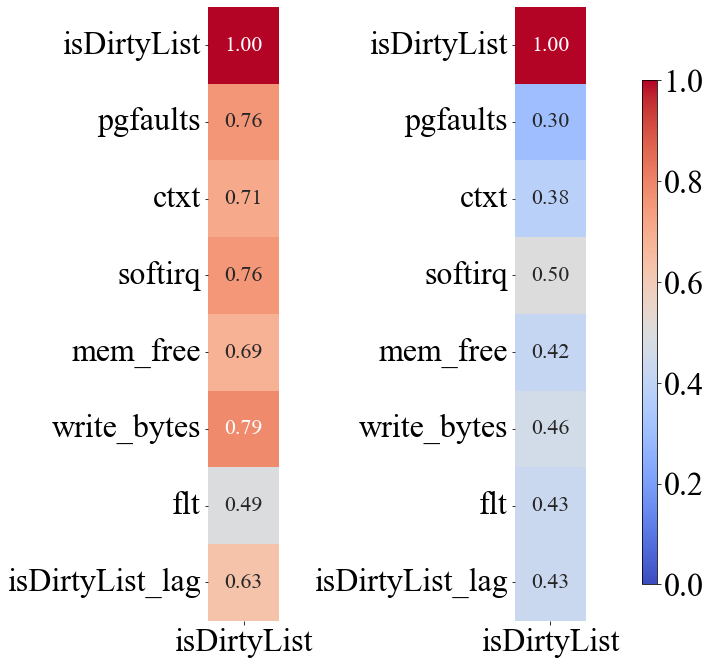

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# pgfaults ctxt softirq mem_free write_bytes flt
# Set the font and plot configurations for PDF output
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 32  # May need further adjustment
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
label_size = 44
tick_size = 32
linewidth = 2.5
legend_size = 28
mark_size = 10
bwith = 2
def plt_hot2(corr_matrix1, corr_matrix2, name):
    # Extract the first column and drop NaN values
    first_col1 = corr_matrix1.iloc[:, 0].dropna()
    first_col2 = corr_matrix2.iloc[:, 0].dropna()
    
    # Convert non-NaN elements to DataFrame
    first_col_df1 = pd.DataFrame(first_col1)
    first_col_df2 = pd.DataFrame(first_col2)

    # Calculate the global minimum and maximum values
    vmin = min(first_col_df1.min().min(), first_col_df2.min().min(), 0)
    vmax = max(first_col_df1.max().max(), first_col_df2.max().max(), 1)

    # Increase figure width and adjust the height as needed to prevent overlap
    fig_width = 10  # Adjust width as needed
    fig_height = 10  # Keep the height or adjust as needed
    fig, ax = plt.subplots(1, 2, figsize=(fig_width, fig_height))

    # Plot the heatmaps
    sns.heatmap(first_col_df1, ax=ax[0], annot=True, fmt=".2f", cmap='coolwarm', vmin=vmin, vmax=vmax,
                annot_kws={"size": 22}, cbar=False)
    ax[0].tick_params(axis='y', labelsize=32)

    sns.heatmap(first_col_df2, ax=ax[1], annot=True, fmt=".2f", cmap='coolwarm', vmin=vmin, vmax=vmax,
                annot_kws={"size": 22}, cbar=False)
    ax[1].tick_params(axis='y', labelsize=32)

    # Add a color bar to the right of the heatmaps
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping

    plt.savefig(f'{name}.pdf', format='pdf', bbox_inches='tight', dpi=300)  # Save as PDF with high resolution
    plt.show()
plt_hot2(corr_matrix_list[50],corr_matrix_list[988],"mem_hot")

/var/folders/zr/dvb9txgj40b71t1ywfg0xl3m0000gn/T/ipykernel_6235/4274308145.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping


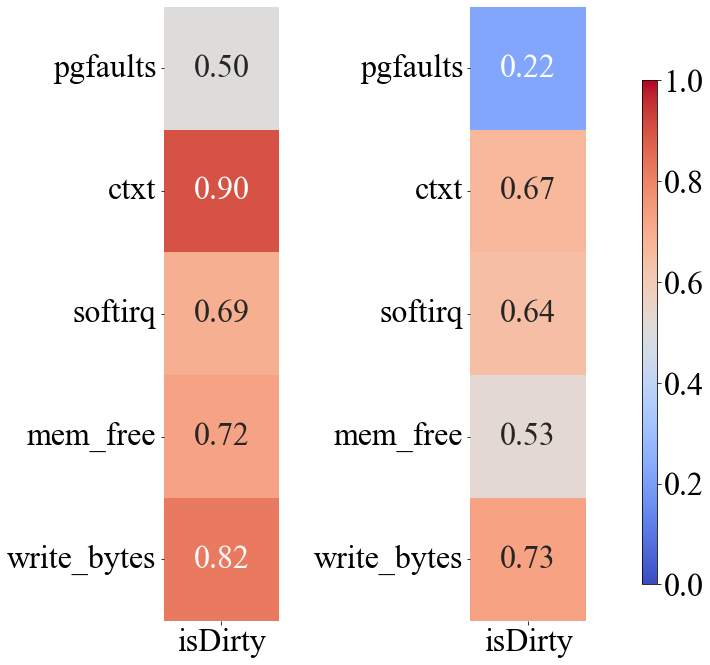

In [9]:
plt_hot2(corr_matrix_list[0],corr_matrix_list[800],"mysql_hot")

/var/folders/zr/dvb9txgj40b71t1ywfg0xl3m0000gn/T/ipykernel_8464/4274308145.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to prevent clipping


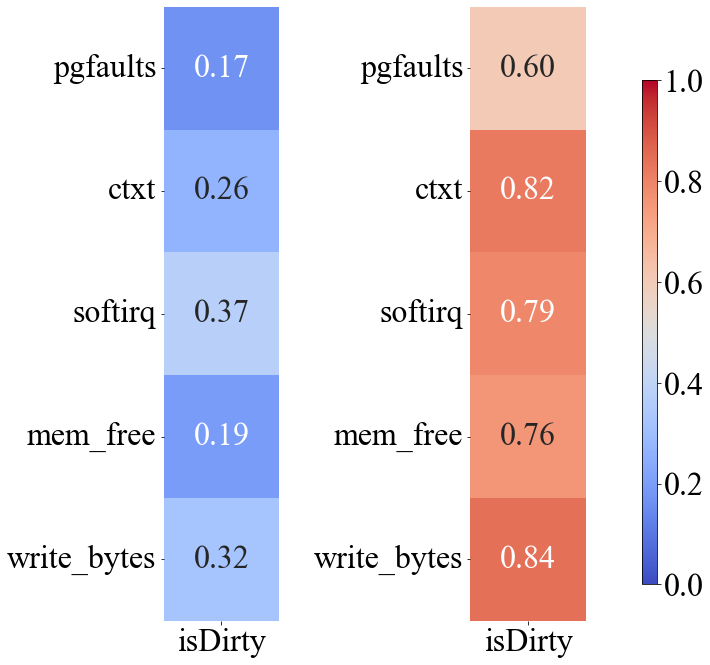

In [5]:
plt_hot2(corr_matrix_list[400],corr_matrix_list[600],"cifar_hot")